# 决策树

- 3.1 决策树的构造

- *3.2 在 Python 中使用 Matplotlib 注解绘制树形图

- 3.3 测试和存储分类器

- 3.4 示例：使用决策树预测隐形眼镜类型

参考文献：李航《统计学习方法》第5章中的5.1-5.3节


在构建一个决策树模型时，我们对某个属性分割节点，下面四张图中，哪个属性对应的信息增益最大？
![](images/20181010090020.png)

目标是什么？

    最终目标是建立一个决策树的classifier， 所使用的算法是 Classification and Regression Tree (CART).

    目标细分为：
        将classifier 作的尽量普遍化， 可以适合各种数据处理，不仅仅是书上的例子。
        将classifier 封装在一个class 里面， 最主要的method 包括训练（fit）， 预测（predict）。



**《统计学习方法》决策树部分**

    ID3, C4.5， CART 的不同之处
        CART 是最普遍使用的， 可以用来作regression 和 classification。 二叉树
        ID3 已经过时， 只能作classification. 多叉数
        C4.5 ID3 的升级版， 可以作classification 和 regression。

    建立决策树时所使用的衡量单位（gini impurity, entropy).
        ID3 C4.5 ----> entropy
        CART ------> gini impurity
        这个并不是绝对的， 所以我们将把两种metric 都包括在class 里面， 把metric 的选择作为一个hyperparameter

    树结构需要使用编程中递归的概念， 所以需要了解一些递归的知识。



* 起初， 这个世界没有树。 只有一堆数据。 这堆数据可以看成是节点（node).
* 向数据提出一个问题。
* 根据问题的结果（是或者不是）， 从而将数据一分为二。 --> 从一个node 变成了两个 node。
* 使用info_gain 来判断此分类是否有效。 而info_gain 是通过分前的节点（node）和分后的两个节点（node） 的impurity 或者 entropy的相差而得来的。
* 经过多次验证， 我们终于得到了最好的info_gain, 同时也知道了什么问题在这个时候该问， 什么时候不该问。
* 最终， 分裂后的节点里面只包括一种类别， 这个节点就不能再分裂了， 我们叫这个节点 leaf（叶子).
* 所以叶子就是不能再分裂了， 而node 还可以继续分裂。 一定要知道他们的不同之处。 leaf 和 node 共同组成了 decision tree。 Leaf 所包含的信息就是我们所需要的prediction。


**常用概念**


    变量 (名词）：
        Node （节点）
        Leaf （叶子）
        Question （问题）

    函数 (动词）：
        split (分裂节点）
        ask question （问问题来判断）
        get_metric (计算 impurity 或者 entropy）
        get_info_gain (计算 info_gain)
        get_best_split (获得最好的分裂）


In [26]:
import numpy as np
from math import log
import operator

## 信息增益

In [27]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    #change to discrete values
    return dataSet, labels

In [28]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2) #log base 2
    return shannonEnt

In [29]:
mydat, labels = createDataSet()

In [30]:
mydat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [31]:
calcShannonEnt(mydat)

0.9709505944546686

## 划分数据集

In [32]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [33]:
mydat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [34]:
splitDataSet(mydat, 2, 'yes')

[[1, 1], [1, 1]]

In [35]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#提取出现相应特征
        uniqueVals = set(featList)       #获取特征值集合的字典
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)#分割出对应特征i的其中一个值value
            prob = len(subDataSet)/float(len(dataSet)) #计算对应特征分割的概率pi
            newEntropy += prob * calcShannonEnt(subDataSet)#计算熵值
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature ##返回最好的特征值的index

In [36]:
set([example[0] for example in mydat])

{0, 1}

In [37]:
chooseBestFeatureToSplit(mydat)

0

## 递归构建决策树

In [38]:
def majorityCnt(classList):
    classCount={} 
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0 
        classCount[vote] += 1 #生成classCount，各类计数
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]#排序输出最大类别


In [39]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet] #提取样例里的便签
    if classList.count(classList[0]) == len(classList):
        return classList[0]#停止切分当值存在同一类属性时
    if len(dataSet[0]) == 1: #停止切分当遍历完所有的特征属性的时候
        return majorityCnt(classList) #排序生成最大类别并返回
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [40]:
mytree = createTree(mydat, labels)

In [41]:
splitDataSet(mydat, 1, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no'], [0, 'no']]

In [42]:
labels

['flippers']

In [43]:
mytree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [44]:
mytree['no surfacing'][1]["flippers"][1]

'yes'

## 测试算法，使用决策树执行分类

In [45]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree)[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): #判断一个对象的变量类型
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: 
        classLabel = valueOfFeat
    return classLabel

In [46]:
list(mytree)[0]

'no surfacing'

In [49]:
mydat, labels = createDataSet()
classify(mytree, labels, [1, 0])

'no'

In [51]:
labels

['no surfacing', 'flippers']

## 存储与保存

In [52]:
def storeTree(inputTree, filename):
    import pickle
    with open(filename, 'wb') as fw:
        pickle.dump(inputTree, fw)
        fw.close()

def grabTree(filename):
    import pickle
    with open(filename, 'rb') as fr:
        return pickle.load(fr)


In [53]:
storeTree(mytree, "test.txt")

In [54]:
grabTree('test.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 决策树绘图

In [55]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else: thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree)[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            plotTree(secondDict[key], cntrPt, str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

#def createPlot():
#    fig = plt.figure(1, facecolor='white')
#    fig.clf()
#    createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
#    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
#    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
#    plt.show()

def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

#createPlot(thisTree)

## 使用决策树预测隐形眼镜类型

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'no': {'age': {'young': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}, 'pre': 'soft'}}, 'yes': {'prescript': {'hyper': {'age': {'young': 'hard', 'presbyopic': 'no lenses', 'pre': 'no lenses'}}, 'myope': 'hard'}}}}}}


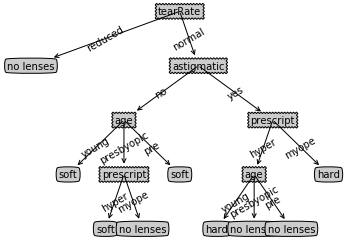

In [64]:
with open('lenses.txt') as fr:
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses,lensesLabels)
print(lensesTree)
createPlot(lensesTree)

In [69]:
lenses

[['young', 'myope', 'no', 'reduced', 'no lenses'],
 ['young', 'myope', 'no', 'normal', 'soft'],
 ['young', 'myope', 'yes', 'reduced', 'no lenses'],
 ['young', 'myope', 'yes', 'normal', 'hard'],
 ['young', 'hyper', 'no', 'reduced', 'no lenses'],
 ['young', 'hyper', 'no', 'normal', 'soft'],
 ['young', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['young', 'hyper', 'yes', 'normal', 'hard'],
 ['pre', 'myope', 'no', 'reduced', 'no lenses'],
 ['pre', 'myope', 'no', 'normal', 'soft'],
 ['pre', 'myope', 'yes', 'reduced', 'no lenses'],
 ['pre', 'myope', 'yes', 'normal', 'hard'],
 ['pre', 'hyper', 'no', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'no', 'normal', 'soft'],
 ['pre', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'yes', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'normal', 'hard'],
 ['presbyopic', 

In [67]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesLabels

['age', 'prescript', 'astigmatic', 'tearRate']

In [57]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
classify(lensesTree, lensesLabels, lenses[0][:-1])
#输入标签进行分类预测

'no lenses'

In [71]:
preds = []
for i in range(len(lenses)):
    pred = classify(lensesTree, lensesLabels, lenses[i][:-1])
    preds.append(pred)
print(preds)#打印出每个样例的预测，与样本完全相符合

['no lenses', 'soft', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'no lenses', 'no lenses', 'no lenses', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'no lenses']
